# Using more sophisticated images with Convolutional Neural Network


download cats_and_dogs zip file by open the cmd and type this command:  
curl -o cats_and_dogs.zip https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [4]:
import zipfile

#unzip the file 
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall()

zip_ref.close()

The contents of the .zip are extracted to the base directory ./cats_and_dogs_filtered, which contains train and validation subdirectories for the training and validation datasets (you can ignore vectorize.py in the output in the next cell).

If you recall, the **training set** is the data that is used to tell the neural network model that 'this is what a cat looks like' and 'this is what a dog looks like'. The **validation** set is images of cats and dogs that the neural network will not see as part of the training. You can use this to test how well or how badly it does in evaluating if an image contains a cat or a dog. (See the Machine Learning Crash Course if you want a refresher on training, validation, and test sets.)

These subdirectories in turn each contain cats and dogs subdirectories.

In [5]:
import os

base_dir = "cats_and_dogs_filtered"

print("Contents of base dir:")
print(os.listdir(base_dir))

print("Contents of train dir:")
print(os.listdir(f'{base_dir}/train'))

print("Contents of validation dir:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base dir:
['train', 'validation', 'vectorize.py']
Contents of train dir:
['cats', 'dogs']
Contents of validation dir:
['cats', 'dogs']


assign each of these base directory to use later

In [6]:
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

#directory with training cats and dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

#directory with validation cats and dogs pictures
validation_cats_dir = os.path.join(validation_dir, "cats")
validation_dogs_dir = os.path.join(validation_dir, "dogs")

In [7]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the train and validation directories:

In [8]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


Now, display a batch of 8 cat and 8 dog pictures. You can re-run the cell to see a fresh batch each time:

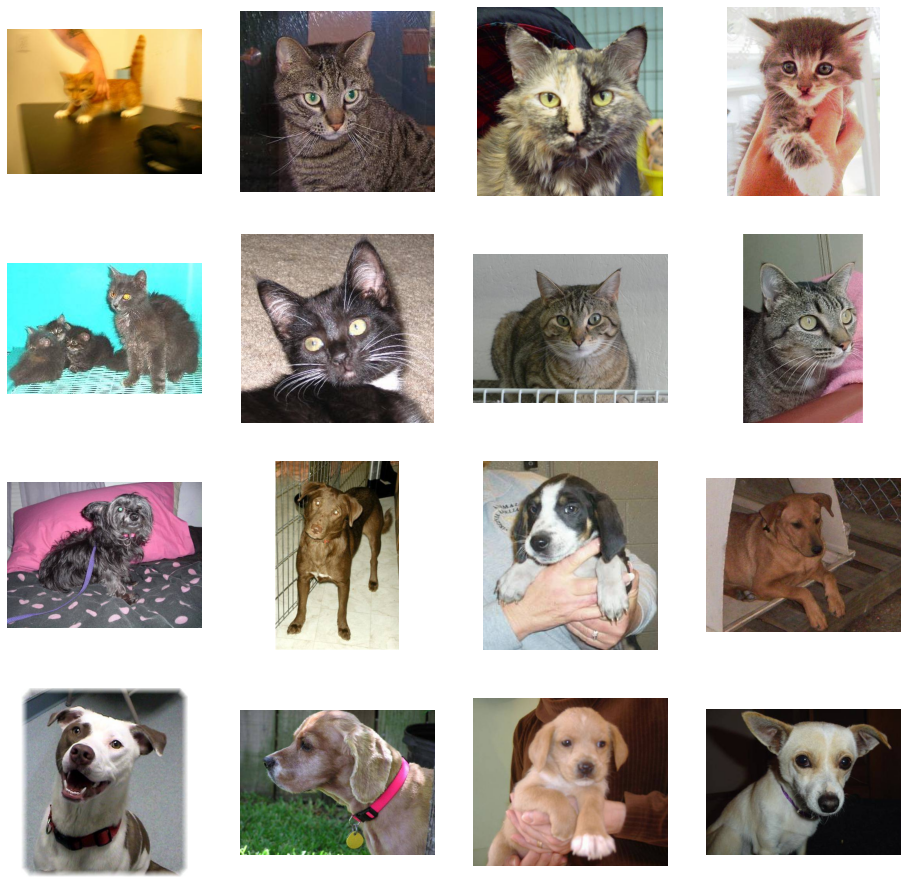

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## build a small model

In [16]:
import tensorflow as tf

model = tf.keras.models.Sequential([
     # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 17, 17, 64)        0

In [21]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### data preprocessing
Next step is to set up the data generators that will read pictures in the source folders, convert them to float32 tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras, this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory).

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#all images will be rescale by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# flow training images with batches of 20 images using ImageGenerator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150)
)

# flow validation images with batches of 20 images using ImageGenerator
test_generator = test_datagen.flow_from_directory(validation_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
You will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.

Do note the values per epoch.

You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy.

The loss and accuracy are great indicators of progress in training. loss measures the current model prediction against the known labels, calculating the result. accuracy, on the other hand, is the portion of correct guesses.

In [22]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=test_generator,
                    verbose=2)

Epoch 1/15
100/100 - 95s - loss: 0.7899 - accuracy: 0.5265 - val_loss: 0.6827 - val_accuracy: 0.5860 - 95s/epoch - 949ms/step
Epoch 2/15
100/100 - 46s - loss: 0.6794 - accuracy: 0.6005 - val_loss: 0.6496 - val_accuracy: 0.6530 - 46s/epoch - 461ms/step
Epoch 3/15
100/100 - 46s - loss: 0.6156 - accuracy: 0.6775 - val_loss: 0.6001 - val_accuracy: 0.6690 - 46s/epoch - 456ms/step
Epoch 4/15
100/100 - 41s - loss: 0.5442 - accuracy: 0.7320 - val_loss: 0.5634 - val_accuracy: 0.7270 - 41s/epoch - 413ms/step
Epoch 5/15
100/100 - 39s - loss: 0.4649 - accuracy: 0.7825 - val_loss: 0.6338 - val_accuracy: 0.6730 - 39s/epoch - 385ms/step
Epoch 6/15
100/100 - 39s - loss: 0.3977 - accuracy: 0.8180 - val_loss: 0.6078 - val_accuracy: 0.7080 - 39s/epoch - 391ms/step
Epoch 7/15
100/100 - 38s - loss: 0.3092 - accuracy: 0.8620 - val_loss: 0.6147 - val_accuracy: 0.7280 - 38s/epoch - 385ms/step
Epoch 8/15
100/100 - 39s - loss: 0.2174 - accuracy: 0.9150 - val_loss: 0.8381 - val_accuracy: 0.6860 - 39s/epoch - 388

### model prediction

['beagle-hound-dog.jfif', 'download (1).jfif', 'download (2).jfif', 'download.jfif']

1/1 [==============================] - 0s 234ms/step
[0.7731296]


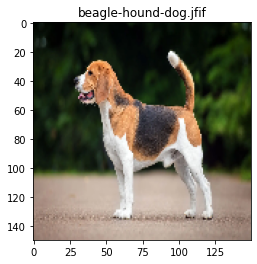

beagle-hound-dog.jfif is a dog

1/1 [==============================] - 0s 80ms/step
[0.01551142]


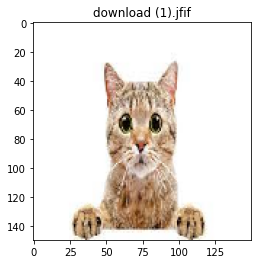

download (1).jfif is a cat

1/1 [==============================] - 0s 96ms/step
[1.]


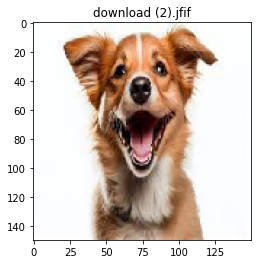

download (2).jfif is a dog

1/1 [==============================] - 0s 52ms/step
[0.00308792]


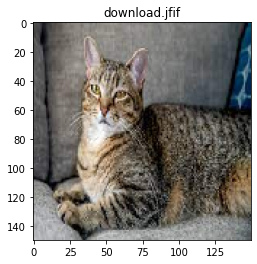

download.jfif is a cat


In [25]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

images = os.listdir("/machine learning/Course 2/images")
print(images)

for i in images:
    print()
    # predicting images
    path = '/machine learning/Course 2/images/' + i
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])

    plt.imshow(img)
    plt.title(i)
    plt.show()

    if classes[0]>0.5:
        print(i + " is a dog")
    else:
        print(i + " is a cat")

### visualize intermediate representations
To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 [==============================] - 0s 248ms/step


C:\Users\MYPC~1\AppData\Local\Temp/ipykernel_12900/2245300094.py:42: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
C:\Users\MYPC~1\AppData\Local\Temp/ipykernel_12900/2245300094.py:45: RuntimeWarning: invalid value encountered in cast
  x  = np.clip(x, 0, 255).astype('uint8')


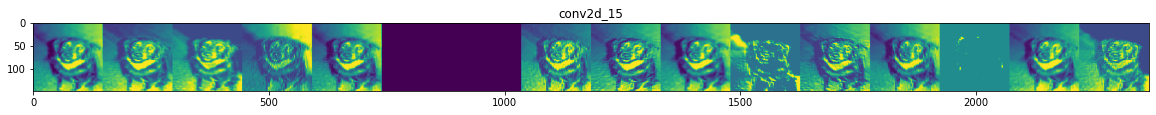

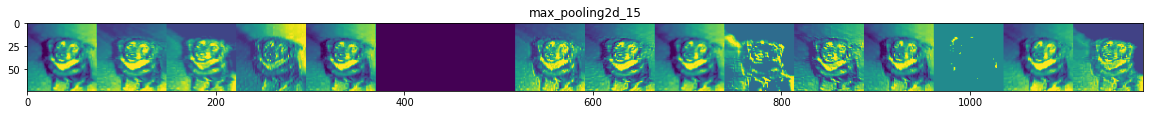

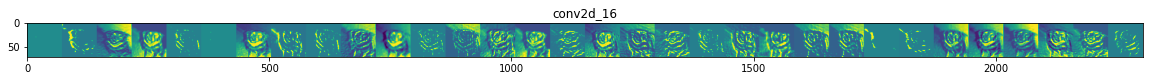

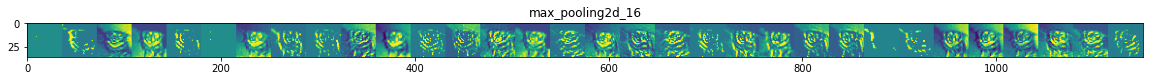

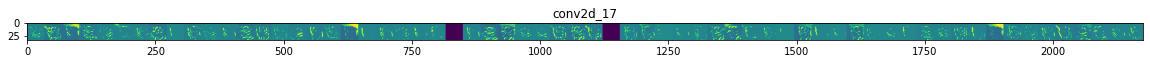

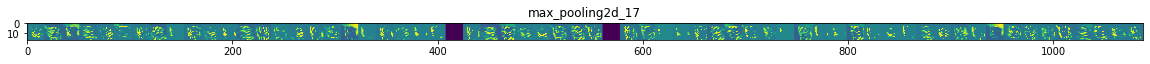

In [28]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

#define a new model that will take an image as input, and will output
#intermediate for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

#prepare a random input image from training dataset
cat_image_file = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_image_file = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_image_file + dog_image_file)
img = load_img(img_path, target_size=(150, 150)) # a PIL image
x = img_to_array(img)                            # numpy array with shape (150, 150, 3)
x = x.reshape((1, ) + x.shape)                   # reshape (1, 150, 150, 3)

#scale by /255
x /= 255.0

#run the image through the network, thus obtaining all intermediate representation for this image
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

#display the presentation
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1] #number of features in the feature_map
        size = feature_map.shape[1] # feature shape (1, 150, 150, 3)

        #title the images in the matrix
        display_grid = np.zeros((size, size*n_features))

        # Postprocess the feature to be visually palatable
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #display the grid
        scale = 20./n_features
        plt.figure(figsize=(scale*n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid.

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called representation sparsity and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

### evaluate the loss and accuracy of the model

Text(0.5, 1.0, 'Training and validation loss')

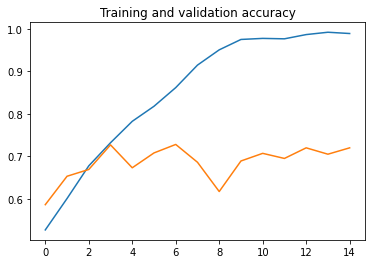

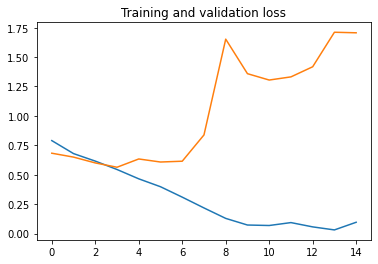

In [31]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot( epochs,     acc )
plt.plot( epochs, val_acc )
plt.title('Training and validation accuracy')
plt.figure() # training is blue, validation is orange

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss')